In [32]:
import os
import sys
import json
import argparse
from collections import Counter
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,random_split,SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [33]:
from matplotlib import pyplot as plt

In [34]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_cont = torch.tensor(self.dataframe.iloc[idx]['X_cont'], dtype=torch.float32)

        other_cols = self.dataframe.drop(columns=['label', 'X_cont','Unit1'])
        x_other = torch.tensor(other_cols.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.dataframe.iloc[idx]['label'], dtype=torch.long)
        
        return x_cont, x_other, label

In [35]:
class BayesianCNN(nn.Module):
    def __init__(self, dyn_channels=5, stat_channels=32):
        super(BayesianCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(dyn_channels, 10, kernel_size=3, padding=1) # 9
        self.bn1 = nn.BatchNorm1d(10)
        self.conv2 = nn.Conv1d(10, 20, kernel_size=3, padding=1) # 8
        self.bn2 = nn.BatchNorm1d(20)
        self.conv3 = nn.Conv1d(20, 30, kernel_size=3, padding=1) # 7
        self.bn3 = nn.BatchNorm1d(30)
        self.conv4 = nn.Conv1d(30, 25, kernel_size=3, padding=1) # 6
        self.bn4 = nn.BatchNorm1d(25)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv4.weight, nonlinearity='relu')
        self.fc1 = nn.Linear(25*5, 30)
        self.fc2 = nn.Linear(30, 10)
        self.flatten = nn.Flatten()
        self.fc_static1 = nn.Linear(stat_channels, 25)
        self.fc_static2 = nn.Linear(25, 30)
        self.fc_static3 = nn.Linear(30, 10)
        self.softmax = nn.Softmax(-1)
        self.fc_final1 = nn.Linear(20, 10)
        self.fc_final2 = nn.Linear(10,2)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc_static1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc_static2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc_static3.weight, nonlinearity='relu')
        nn.init.xavier_normal_(self.fc_final1.weight)
        nn.init.xavier_normal_(self.fc_final2.weight)

    def forward(self, x_dynamic, x_static):
        
        #x_dynamic = x_dynamic.permute(0,2,1)
        x = self.bn1(self.conv1(x_dynamic))
        x = torch.relu(x)
        x = self.bn2(self.conv2(x))
        x = torch.relu(x)
        x = self.bn3(self.conv3(x))
        x = torch.relu(x)
        x = self.bn4(self.conv4(x))
        x = torch.relu(x)
        x = self.flatten(x) 

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        y = torch.relu(self.fc_static1(x_static))
        y = torch.relu(self.fc_static2(y))
        y = torch.relu(self.fc_static3(y))

        z = torch.cat((x, y), dim=1)
        z = self.softmax(self.fc_final2((torch.relu(self.fc_final1(z)))))
        return z
    def model(self, x_dynamic, x_static, y=None):
        # Define prior distributions for all neural network weights
        priors = {
            'conv1.weight': dist.Normal(0, 1).expand([10, x_dynamic.size(1), 3]).to_event(3),
            'conv2.weight': dist.Normal(0, 1).expand([20, 10, 3]).to_event(3),
            'conv3.weight': dist.Normal(0, 1).expand([30, 20, 3]).to_event(3),
            'conv4.weight': dist.Normal(0, 1).expand([25, 30, 3]).to_event(3),
            'fc1.weight': dist.Normal(0, 1).expand([30, 25*5]).to_event(2),
            'fc2.weight': dist.Normal(0, 1).expand([10, 30]).to_event(2),
            'fc_static1.weight': dist.Normal(0, 1).expand([25, x_static.size(1)]).to_event(2),
            'fc_static2.weight': dist.Normal(0, 1).expand([30, 25]).to_event(2),
            'fc_static3.weight': dist.Normal(0, 1).expand([10, 30]).to_event(2),
            'fc_final1.weight': dist.Normal(0, 1).expand([10, 20]).to_event(2),
            'fc_final2.weight': dist.Normal(0, 1).expand([2, 10]).to_event(2)
        }
        lifted_module = pyro.random_module("module", self, priors)  # Lift module parameters to random variables
        lifted_reg_model = lifted_module()

        # Condition on the observed data
        with pyro.plate("data", x_dynamic.size(0)):
            prediction = lifted_reg_model(x_dynamic, x_static)
            pyro.sample("obs", dist.Categorical(probs=prediction), obs=y)

    # Defining the guide function for variational inference
    def guide(self, x_dynamic, x_static, y=None):
        # Define variational distributions for the parameters (learnable)
        softplus = torch.nn.Softplus()
        priors = {
            'conv1.weight': dist.Normal(torch.randn([10, x_dynamic.size(1), 3]), softplus(torch.randn([10, x_dynamic.size(1), 3]))).to_event(3),
            'conv2.weight': dist.Normal(torch.randn([20, 10, 3]), softplus(torch.randn([20, 10, 3]))).to_event(3),
            'conv3.weight': dist.Normal(torch.randn([30, 20, 3]), softplus(torch.randn([30, 20, 3]))).to_event(3),
            'conv4.weight': dist.Normal(torch.randn([25, 30, 3]), softplus(torch.randn([25, 30, 3]))).to_event(3),
            'fc1.weight': dist.Normal(torch.randn([30, 25*5]), softplus(torch.randn([30, 25*5]))).to_event(2),
            'fc2.weight': dist.Normal(torch.randn([10, 30]), softplus(torch.randn([10, 30]))).to_event(2),
            'fc_static1.weight': dist.Normal(torch.randn([25, x_static.size(1)]), softplus(torch.randn([25, x_static.size(1)]))).to_event(2),
            'fc_static2.weight': dist.Normal(torch.randn([30, 25]), softplus(torch.randn([30, 25]))).to_event(2),
            'fc_static3.weight': dist.Normal(torch.randn([10, 30]), softplus(torch.randn([10, 30]))).to_event(2),
            'fc_final1.weight': dist.Normal(torch.randn([10, 20]), softplus(torch.randn([10, 20]))).to_event(2),
            'fc_final2.weight': dist.Normal(torch.randn([2, 10]), softplus(torch.randn([2, 10]))).to_event(2),
        }
        lifted_module = pyro.random_module("module", self, priors)  # Lift module parameters to random variables
        return lifted_module()

In [36]:
trainval_df = pd.read_pickle('train.pkl').reset_index(drop=True)
        
class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1) 
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)
      
N = len(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
val = train_df[:int(N*0.2)]
train_df = train_df[int(N*0.2):]
train_df.fillna(value=np.pi, inplace=True)
val.fillna(value=np.pi, inplace=True)

In [37]:
print(train_df.shape)
print(val.shape)

(28245, 35)
(7061, 35)


In [38]:
train_dataset = SequenceDataset(train_df)
valid_dataset = SequenceDataset(val)
train_num = len(train_dataset)
val_num = len(valid_dataset)
batch_size=20
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
    
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

print("using {} samples for training, {} samples for validation.".format(train_num,
                                                                           val_num))

Using 8 dataloader workers every process
using 28245 samples for training, 7061 samples for validation.


In [39]:
sample = train_dataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
for x_dynamic, x_static, y in train_loader:
    print(x_dynamic.shape)
    print(x_static.shape)
    print(y.shape)
    break

torch.Size([10, 5])
torch.Size([32])
tensor(1)
torch.Size([20, 10, 5])
torch.Size([20, 32])
torch.Size([20])


In [40]:
def train(model, train_loader, valid_loader, num_epochs=30):
    if torch.cuda.is_available():
        model = model.cuda()
    optim = Adam({"lr": 0.001})
    svi = SVI(model.model, model.guide, optim, loss=Trace_ELBO())
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y in train_loader:
            model.train()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            loss = svi.step(x_dynamic, x_static, y)
            total_loss += loss
            model.eval()
            with torch.no_grad():
                lifted_module = model.guide(x_dynamic, x_static, y)
                pred = lifted_module(x_dynamic, x_static)
                pred_label = torch.argmax(pred, dim=-1)
            correct += (pred_label == y).sum().item()
            total += y.shape[0]
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")
        train_loss_list.append(epoch_loss)

        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y in train_loader:
            model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            with torch.no_grad():
                loss = svi.step(x_dynamic, x_static, y)
                total_loss += loss
                lifted_module = model.guide(x_dynamic, x_static, y)
                pred = lifted_module(x_dynamic, x_static)
                pred_label = torch.argmax(pred, dim=-1)
                correct += (pred_label == y).sum().item()
                total += y.shape[0]
            epoch_loss = total_loss / len(valid_loader)
        epoch_accuracy = correct / total
        valid_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}")
        valid_loss_list.append(epoch_loss)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [41]:
model = BayesianCNN(dyn_channels=5, stat_channels=32)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(model, train_loader, valid_loader, num_epochs=30)

/Users/zhaoxiuheng/anaconda3/envs/course/lib/python3.7/site-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


Epoch 1, Train Loss: 10135.75485529498, Train Accuracy: 0.5010798371393167
Epoch 1, Validation Loss: 40467.640551320575, Validation Accuracy: 0.4944237918215613
Epoch 2, Train Loss: 10133.7552600689, Train Accuracy: 0.5019295450522216
Epoch 2, Validation Loss: 40426.46892516088, Validation Accuracy: 0.5012922641175429
Epoch 3, Train Loss: 10140.473875251293, Train Accuracy: 0.5044078597981944
Epoch 3, Validation Loss: 40452.07091329192, Validation Accuracy: 0.5010090281465747


Text(0.5, 1.0, 'Accuracy curve')

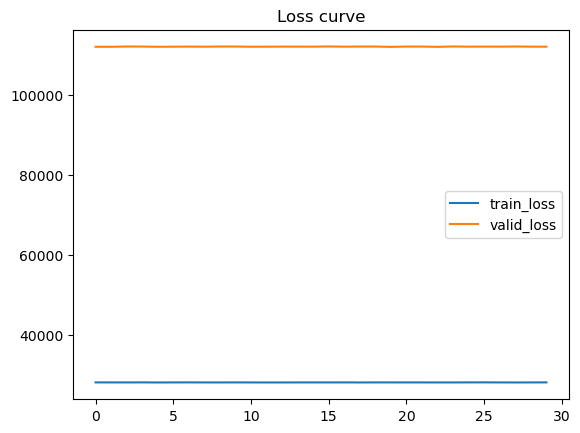

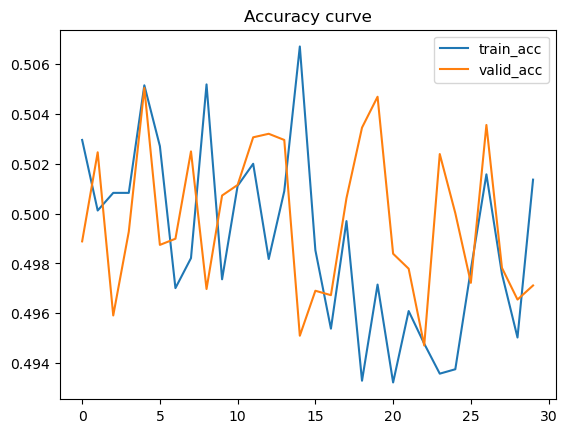

In [ ]:
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend()
plt.title(f"Loss curve")

plt.figure()
plt.plot(train_acc_list, label="train_acc")
plt.plot(valid_acc_list, label="valid_acc")
plt.legend()
plt.title(f"Accuracy curve")